# Mycoplasma Bovis analysis

Links

* https://www.ncbi.nlm.nih.gov/genome/browse/#!/prokaryotes/1150/

Bioprojects:

* Genomic epidemiology of Mycoplasma bovis in France: SRP386998
* Genome-Wide Identification of Variants Associated with Antimicrobial Resistance in Mycoplasma bovis: SRP349146/PRJNA785928
* Sanger Full_genome_sequencing_of_Mycoplasma_species_isolates_from_ruminants (Israel): PRJEB3408
* Mycoplasmopsis bovis Genome sequencing and assembly (China): PRJNA1021812
* WGS Australian Mycoplasma bovis isolates: PRJNA335520
* Comparative genomics of mycoplasma bovis: PRJNA602897 (DTU)
* Mycoplasma bovis genomes from the New Zealand outbreak: PRJNA664415

Refs:

* [Genomics-based epidemiology of bovine Mycoplasma bovis strains in Israel](https://bmcgenomics.biomedcentral.com/articles/10.1186/s12864-020-6460-0#Sec13)
* [Population Genomic Analysis of Mycoplasma bovis Elucidates Geographical Variations and Genes associated with Host-Types](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7650767/)
* [Identification of Antimicrobial Resistance-Associated Genes through Whole Genome Sequencing of Mycoplasma bovis Isolates with Different Antimicrobial Resistances](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7400188/)

In [32]:
import os,sys,subprocess,glob
import numpy as np
import pandas as pd
import pylab as plt
import seaborn as sns
from importlib import reload
from snipgenie import app, tools

In [163]:
#sra samples stats
srafiles = glob.glob('*_runTable.csv')
res=[]
for f in srafiles:
    df=pd.read_csv(f)
    res.append(df)
res=pd.concat(res)
res.geo_loc_name_country.value_counts()
#res[res.geo_loc_name_country=='

geo_loc_name_country
New Zealand    594
Australia       82
Denmark         77
Canada          70
USA             27
France          14
Sweden          10
Netherlands      9
Finland          1
Estonia          1
Name: count, dtype: int64

In [38]:
ref = 'NC_014760.fa'
refgb = 'NC_014760.gb'

In [155]:
samples=pd.read_csv('results/samples.csv',index_col=0)
meta=pd.read_csv('metadata.csv')
meta = meta[meta.status!='removed']

In [156]:
samples = samples.merge(meta,on='sample', how='left')

In [157]:
dm = pd.read_csv('results/snpdist.csv',index_col=0)

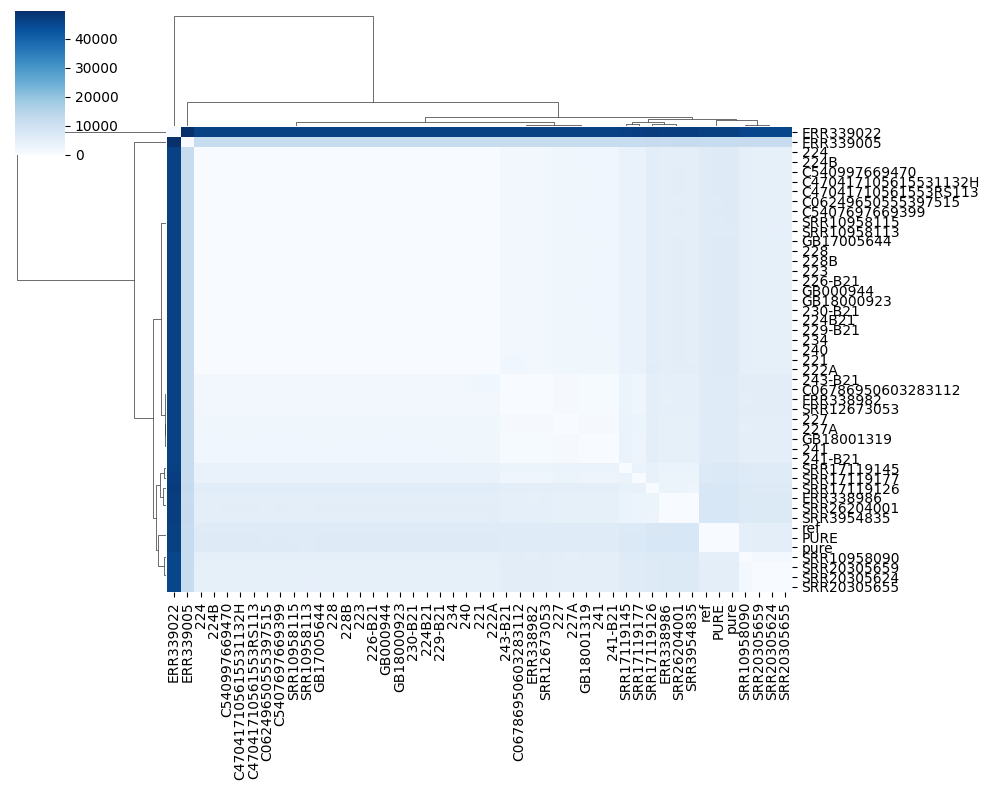

In [158]:
cg=sns.clustermap(dm, cmap='Blues', xticklabels=True, yticklabels=True, figsize=(10,8))

In [ ]:
ire = list(meta[meta.country=='Ireland']['sample'])
dm.loc[ire,ire]

In [159]:
#C=pd.read_csv('results/csq.matrix').T
csq = app.read_csq_file('results/csq.tsv')
aamat = app.get_aa_snp_matrix(csq)

## check duplicates

In [160]:
for pair,df in samples.groupby('pair'):
    if len(df) == 1:
        continue        
    print (pair)
    #print (df)
    x=list(df['sample'])        
    print (dm.loc[x,x])

224
      224  224B
224     0     5
224B    5     0
227
      227  227A
227     0     8
227A    8     0
228
      228  228B
228     0     5
228B    5     0
241
         241  241-B21
241        0        4
241-B21    4        0
C470417
                      C470417105615531132H  C47041710561553RS113
C470417105615531132H                     0                     2
C47041710561553RS113                     2                     0
pure
      PURE  pure
PURE     0     1
pure     1     0


In [161]:
tools.get_unique_snps(['227A'],aamat)

,,,sample,221,222A,223,224,224B,224B21,226-B21,227,227A,228,...,SRR12673053,SRR17119126,SRR17119145,SRR17119177,SRR20305624,SRR20305655,SRR20305659,SRR26204001,SRR3954835,pure
start,gene,aa,snp_type,,,,,,,,,,,,,,,,,,,,,


## deletions

In [9]:
from snipgenie import rdiff
sub=samples.sample(10,random_state=2)
regions = rdiff.get_deletions(samples, ref, refgb, #mask_file=app.mbovis_mask,
                              label='sample', min_coverage=0, n_cores=12)
regions.to_csv('deletion_regions.csv',index=False)

In [ ]:
regions = pd.read_csv('deletion_regions.csv')
res=regions[regions.length>2000]
X=pd.pivot_table(res,index=['group','genes'],columns='name',values='length').fillna(0)
X=X.clip(0,1)
X=X.droplevel(1)

sns.clustermap(X,cmap='Blues',yticklabels=True,row_cluster=False,lw=.4,linecolor='.8',figsize=(14,10))

#write a mask file?
#X

In [ ]:
s=590804;e=s+1000
rdiff.show_coverage(samples, 'NC_014760.1',s,e,ref,refgb,margin=1300)

## assembly

In [ ]:
for i,r in df[:-8].iterrows():    
    name = r['sample']
    print (name)
    if name in ['pure']: continue
    tools.spades(r.filename1,r.filename2, os.path.join('assembly',name), 'assembly/%s.fa' %name, 12)

## annotation

In [ ]:
out='annot'
files = glob.glob('assembly/*.fa')
a = [os.path.basename(i) for i in files]
trusted = 'CP002188.gb'

for f in files:
    n = os.path.splitext(os.path.basename(f))[0]
    cmd = '/local/prokka/bin/prokka --proteins {p} --outdir {o}/{n} {f} --prefix {n}'.format(p=trusted,f=f,n=n,o=out)#,p=path)    
    if not os.path.exists('%s/%s' %(out,n)):
        print (cmd)
        subprocess.check_output(cmd, shell=True)

In [102]:
files = glob.glob('annot/**/*.gff',recursive=True)
import shutil
for f in files:   
    shutil.copy(f, os.path.join('gff_annot',os.path.basename(f)))
    

## roary

In [87]:
def get_presence_absence(df, cols=None):
    """parse roary file"""
    if cols is None:
        cols = df.columns[14:]
    x=df.copy()
    x['cat'] = x.Annotation.apply(lambda x: apply_cat(x))
    x = x.set_index(['cat','Gene','Annotation'])
    x = x[cols].notnull().astype('int')
    #x = x.loc[x.index.dropna()]
    return x

def apply_cat(x):
    keys=['ARO','efflux','adhesin','LEE','porin','stress',
          'secretion system', 'bacteriophage',
          'membrane','prophage','secreted','IS','insertion','transposase','integrase',
          'virulence','protease','stress','toxic','phage','kinase','phosphatase',
          'hypothetical','membrane','binding','rna','ribosomal','tRNA','methyltransferase',
         'polymerase','DNA','Transcription','lipoprotein','protease']
    for i in keys:
        if x is np.nan: return
        if i in x:
            return i
    return 'other'
    
def genes_clustermap(x,xticklabels=0,title=''):    
    """plot cluster map of genes"""
    from matplotlib.colors import ListedColormap, LogNorm
    #x = x[x.sum(1)>=1]
    sys.setrecursionlimit(20000)
    clrs = ["lightgray", "black"]
    t_cmap = ListedColormap(sns.color_palette(clrs).as_hex())
    if len(x)>50:
        yticklabels=0
    if len(x.T)>50:
        xticklabels=0
    cg=sns.clustermap(x,xticklabels=xticklabels,yticklabels=1,cmap=t_cmap,figsize=(12,7))
    cg.fig.suptitle(title)
    cg.fig.subplots_adjust(right=0.8)
    return

In [ ]:
cmd = 'roary -f roary_out -e -n -v -z -i 85 -cd 70 -p 8 gff_annot/*.gff'
subprocess.check_output(cmd, shell=True)

In [136]:
roary = pd.read_csv('roary_out/gene_presence_absence.csv')
x = get_presence_absence(roary)

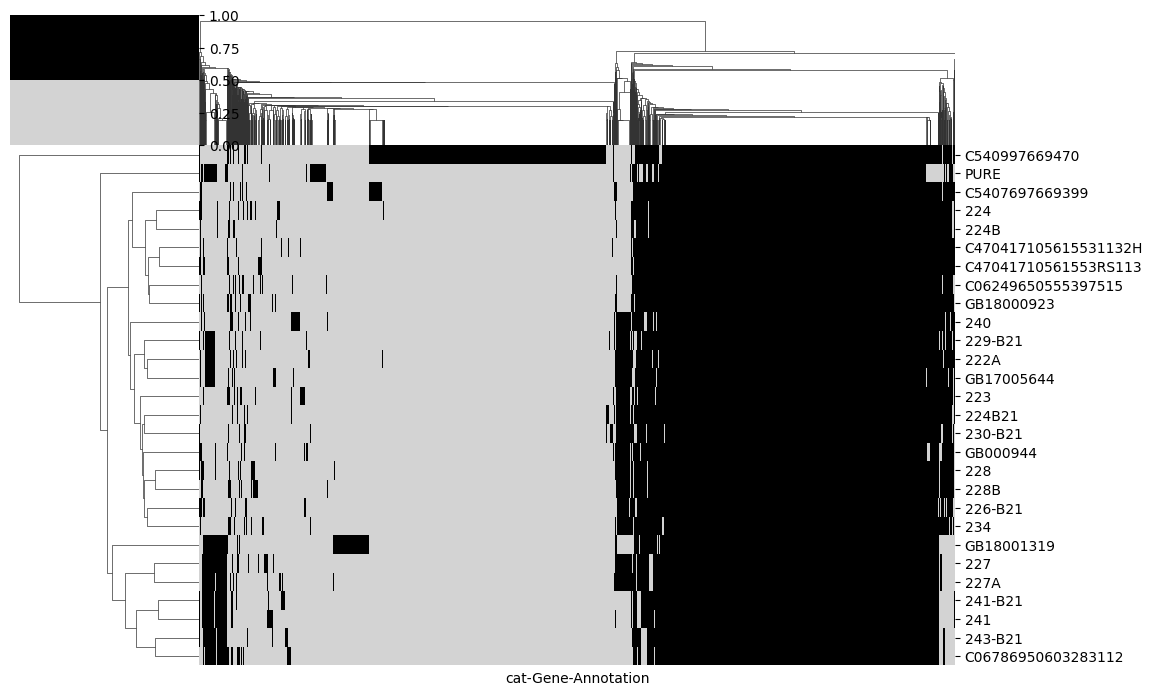

In [137]:
genes_clustermap(x.T)

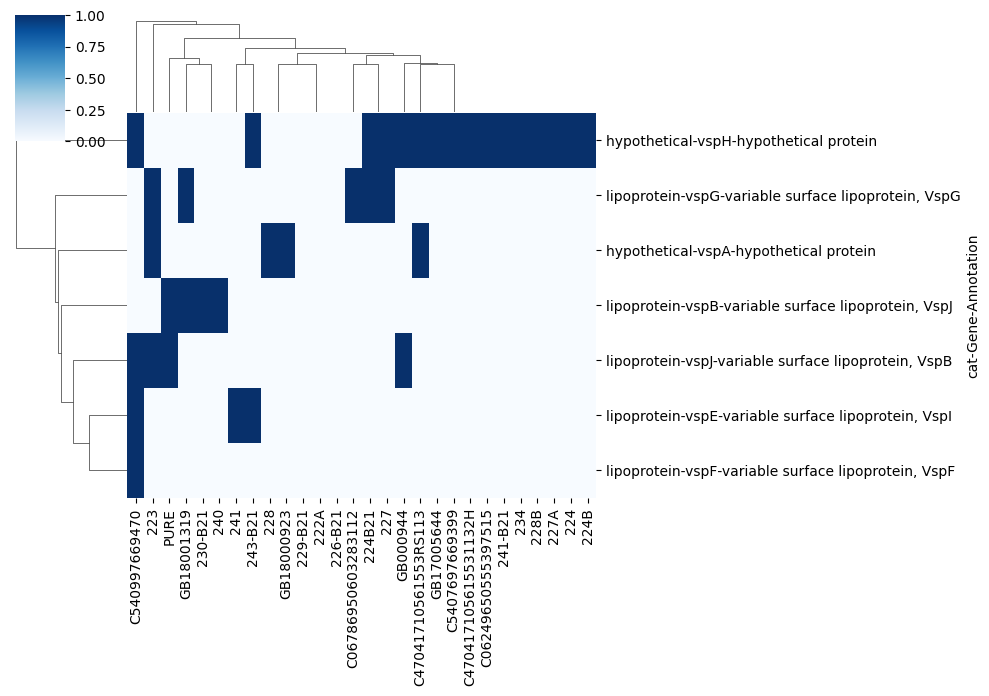

In [144]:
genes=['vspJ','vspB','vspA','vspH','vspE','vspF','vspG']
v=x.loc[:,genes,:]
#f,ax=plt.subplots(1,1,figsize=(10,10))
sns.clustermap(v,xticklabels=True,figsize=(10,7),cmap='Blues')

## VSP genes?

In [ ]:
#read annot 


## AMR/virulence gene detection

## AMR SNPs

In [ ]:
C=pd.read_csv('results/csq.matrix')
C.snp_type.value_counts()

In [ ]:
S=C[C.snp_type=='stop_lost']
S

In [ ]:
M=C[C.snp_type=='missense']
freq = M.iloc[:,4:].sum(axis=1)
M=M[freq>4]
M=C[C.snp_type=='stop_lost']

In [ ]:
X=C.iloc[:,4:]
#colors,colormap=plotting.get_color_mapping(C,county1',cmap='Set1')
cg = sns.clustermap(X,xticklabels=False,yticklabels=False,cmap='gray_r',cbar_pos=None,figsize=(17,10)) #row_colors=[colors1,colors2]


## coverage

In [ ]:
reload(tools)
n=8
fig,ax=plt.subplots(n-1,1,figsize=(25,12))
axs=ax.flat
i=0
for idx,r in df.sample(n).iterrows(): 
    #print (r.bam_file)
    if pd.isnull(r.bam_file): continue   
    d=tools.samtools_depth(r.bam_file, start=180000,end=300000)
    x=groupby_interval(d,500,1000)
    ax=axs[i]
    x.plot(kind='area',ax=ax)
    label = r['sample']
    ax.text(.05,.8,label,color='blue',transform=ax.transAxes,fontsize=12)
    ax.set_xticklabels([])
    i+=1
sns.despine()
plt.tight_layout()

In [5]:
def groupby_interval(df, clip=2, interval=100):
    """Group over an interval - used for samtools depth data"""
    
    min = df.pos.min()
    max=df.pos.max()
    b = np.arange(min, max, interval)
    #rint (b)
    x=df.groupby(pd.cut(df.pos, bins=b, labels=b[:-1], right=False)).mean(numeric_only=True)['depth']
    x = x.clip(0,clip)
    x = x.replace(0,np.nan)
    return x.dropna()

In [ ]:
d=tools.samtools_depth('results/mapped/222A.bam')
data=groupby_interval(d,500,1000).dropna()
data

In [ ]:
from pycirclize import Circos
from pycirclize.parser import Genbank
from pycirclize.utils import load_prokaryote_example_file
import numpy as np
from matplotlib.patches import Patch

# Load Genbank file
gbk_file = 'NC_014760.gb'
gbk = Genbank(gbk_file)

circos = Circos(sectors={gbk.name: gbk.range_size}, start=0, end=320)
sector = circos.get_sector(gbk.name)
major_ticks_interval = 200000
minor_ticks_interval = 50000
outer_track = sector.add_track((98, 100))
outer_track.axis(fc="lightgrey")
outer_track.xticks_by_interval(
    major_ticks_interval, label_formatter=lambda v: f"{v/ 10 ** 6:.1f} Mb"
)
outer_track.xticks_by_interval(minor_ticks_interval, tick_length=1, show_label=False)

f_cds_track = sector.add_track((90, 97), r_pad_ratio=0.1)
f_cds_track.genomic_features(gbk.extract_features("CDS", target_strand=1), fc="red")
r_cds_track = sector.add_track((83, 90), r_pad_ratio=0.1)
r_cds_track.genomic_features(gbk.extract_features("CDS", target_strand=-1), fc="blue")

n=8
i=70
h=6
text_common_kws = dict(ha="right", va="center", size=8)
for idx,r in df.sample(n).iterrows(): 
    name = r['sample']
    if pd.isnull(r.bam_file): continue   
    d = tools.samtools_depth(r.bam_file)#, start=200000,end=350000)
    data = groupby_interval(d,500,2000)
    x=data.index
    y=data.values
    track = sector.add_track((i, i+h), r_pad_ratio=0.1)
    track.axis()
    #track.line(x, y)
    track.fill_between(x, y, ec="black", lw=.2)
    i-=h
    circos.text(name, r=i+h+2, color="black", **text_common_kws)

fig = circos.plotfig(160)

In [ ]:
from pycirclize import Circos
from io import StringIO
from Bio import Phylo
import numpy as np

np.random.seed(0)

tree = Phylo.read('results/tree.newick', "newick")
leaf_num = tree.count_terminals()

# Initialize circos sector with tree size
circos = Circos(sectors={"Tree": leaf_num}, start=-350, end=0)
sector = circos.sectors[0]

# Plot tree
tree_track = sector.add_track((30, 80))
tree_track.tree(
    tree,
    use_branch_length=True, 
    leaf_label_size=10,
    leaf_label_margin=2, # Set large margin for heatmap plot
    
)

# Plot heatmap
heatmap_track = sector.add_track((100, 120))
matrix_data = np.random.randint(0, 100, (5, leaf_num))
heatmap_track.heatmap(matrix_data, cmap="viridis")
heatmap_track.yticks([0.5, 1.5, 2.5, 3.5, 4.5], list("ABCDE"), vmax=5, tick_length=0)

fig = circos.plotfig()


## kraken

In [ ]:
reload(tools)
f1 = '/storage/catherine/data/222A_S3_L001-4_R1_001.fastq.gz'
f2 = '/storage/catherine/data/222A_S3_L001-4_R2_001.fastq.gz'
rep=tools.kraken(f1, f2, threads=8)

In [ ]:
res=[]
found = pd.read_csv('/storage/catherine/contam_kraken.csv')
samples = pd.read_csv('/storage/catherine/results/samples.csv')

for i,r in samples.iterrows():
    name = r['sample']
    print (name)
    if name in list(found['sample']):
        continue
    rep = tools.kraken(r.filename1,r.filename2, threads=8)    
    rep=rep[rep.perc_frag>0.1]    
    rep['sample'] = name
    res.append(rep)
if len(res)>0:
    df=pd.concat(res)
    found = pd.concat([found,df])
    #found = df
    found.to_csv('/other/catherine/contam_kraken.csv',index=False)

<Axes: xlabel='name', ylabel='sample'>

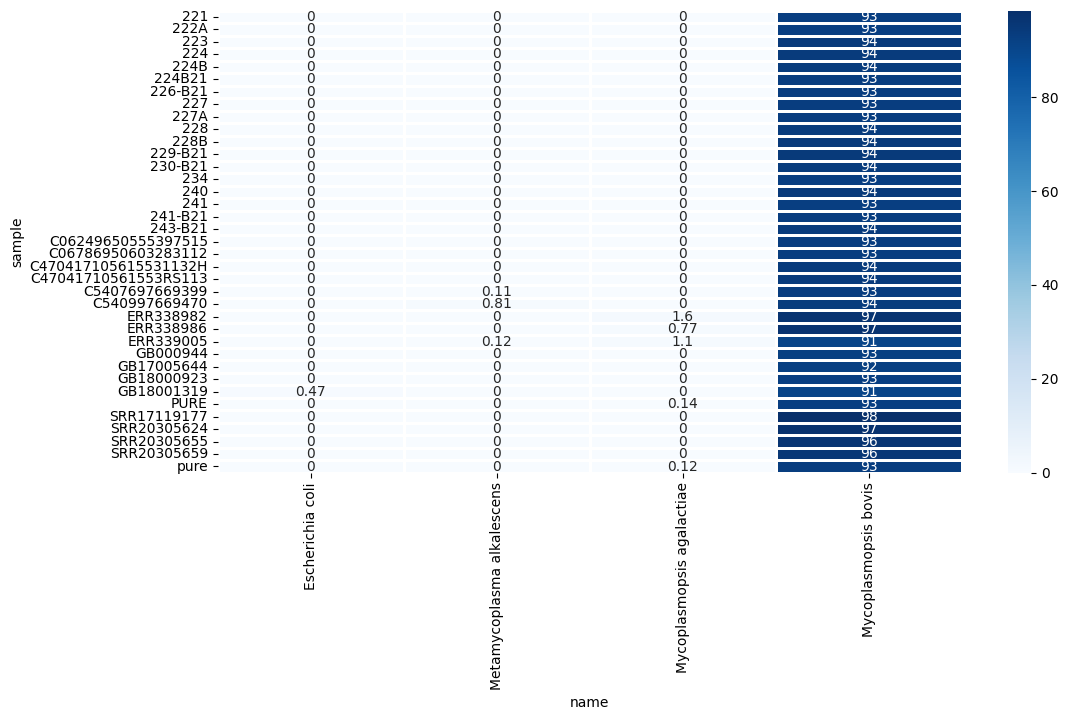

In [133]:
found = pd.read_csv('/other/catherine/contam_kraken.csv')
x=found[found.rank_code=='S']
contam = x.pivot_table(index='sample',columns='name',values='perc_frag').fillna(0)
ax=plt.subplots(1,1,figsize=(12,6))
sns.heatmap(contam,lw=1,cmap='Blues',annot=True,yticklabels=True)